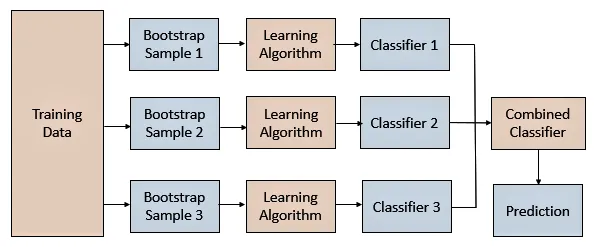

In [ ]:
from random import seed
from random import randrange

In [ ]:
def subsample(dataset,ratio=1.0 ):
  sample = list()
  n_sample = round(len(dataset) * ratio)
  while len(sample)<n_sample:
    index = randrange(len(dataset))
    sample.append(dataset[index])
  return sample
  
def mean(number):
  return sum(number)/float(len(number))
seed(1)

In [ ]:
dataset = [[randrange(10) ]for i in range(20)]
print('true mean : %.3f'%mean([row[0] for row in dataset]))
ratio = 0.10
for size in [1,10,100]:
  sample_means = list()
  for i in range(size):
    sample = subsample(dataset,ratio)
    sample_mean = mean([row[0]for row in sample])
    sample_means.append(sample_mean)
  print('samples = %d, Estimated Mean: %.3f'%(size,mean(sample_means)))


true mean : 4.500
samples = 1, Estimated Mean: 4.000
samples = 10, Estimated Mean: 4.700
samples = 100, Estimated Mean: 4.570


In [48]:
def gini_index(groups,classes):
  n_instances = float(sum([len(group) for group in groups]))
  gini =0.0
  for group in groups:
    size = float(len(group))
    if size ==0:
      continue
    score =0.0
    for class_val in classes:
      p = [row[-1] for row in group].count(class_val)/size
      score += p*p
    gini += (1-score)*(size/n_instances)
  return gini
def test_split(index,value,dataset):
  left,right = list(),list()
  for row in dataset:
    if row[index]<value:
      left.append(row)
    else:
      right.append(row)
  return left,right
def get_split(dataset):
  class_values = list(set(row[-1] for row in dataset))
  b_index , b_value,b_score,b_groups = 999,999,999,None
  for index in range(len(dataset[0])-1):
    for row in dataset:
      groups = test_split(index,row[index],dataset)
      gini = gini_index(groups,class_values)
      if gini <b_score:
        b_index,b_value,b_score,b_groups = index,row[index],gini,groups
  return {'index':b_index,'value':b_value,'groups':b_groups}
def to_terminal(group):
  outcomes = [row[-1] for row in group]
  return max(set(outcomes), key = outcomes.count)
def split(node,max_depth,min_size,depth):
  left,right = node['groups']
  del(node['groups'])
  if not left or not right:
    node['left']= node['right'] = to_terminal(left+right)
    return
  if depth>=max_depth:
    node['left'], node['right'] = to_terminal(left),to_terminal(right)
    return
  if len(left) <= min_size:
    node['left'] = to_terminal(left)
  else :
    node['left'] = get_split(left)
    split(node['left'],max_depth,min_size,depth+1)
  if len(right) <= min_size:
    node['right'] = to_terminal(right)
  else :
    node['right']=get_split(right)
    split(node['right'],max_depth,min_size,depth+1)

def build_tree(train,max_depth,min_size):
  root = get_split(train)
  split(root,max_depth,min_size,1)
  return root
def predict(node,row):
  if row[node['index']] < node['value']:
    if isinstance(node['left'],dict):
      return predict(node['left'],row)
    else:
      return node['left']
  else:
    if isinstance(node['right'],dict):
      return predict(node['right'],row)
    else:
      return node['right']
from random import seed
from random import randrange
from csv import reader
from math import sqrt


def accuracy_metric(actual,predicted):
  correct=0
  for i in range(len(actual)):
     if actual[i] == predicted[i]:
      correct +=1
  return correct/float(len(actual)) * 100.0

def evaluate_algorithm(dataset,algorithm,n_folds,*args):
  folds = cross_validation_split(dataset,n_folds)
  scores = list()
  for fold in folds:
    train_set = list(folds)
    train_set.remove(fold)
    train_set = sum(train_set,[])
    test_set = list()
    for row in fold:
      row_copy = list(row)
      test_set.append(row_copy)
      row_copy[-1] = None
    predicted = algorithm(train_set,test_set,*args)
    actual = [row[-1] for row in fold]
    accur = accuracy_metric(actual,predicted)
    scores.append(accur)
  return scores
def decision_tree(train,test,max_depth,min_size):
  tree = build_tree(train,max_depth,min_size)
  predictions=list()
  for row in test:
    prediction = predict(tree,row)
    predictions.append(prediction)
  return(predictions)

def load_csv(filename):
  dataset = list()
  with open(filename,'r') as file:
    csv_reader = reader(file)
    for row in csv_reader:
      if not row:
        continue
      dataset.append(row)
  return dataset

def str_column_to_float(dataset,column):
  for row in dataset:
    row[column]=float(row[column].strip())

def dataset_minmax(dataset):
  minmax = list()
  for i in range(len(dataset[0])):
    col_values = [row[i] for row in dataset]
    value_min = min(col_values)
    value_max = max(col_values)
    minmax.append([value_min,value_max])
  return minmax

def normalize_dataset(dataset, minmax):
  for row in dataset:
    for i in range(len(row)):
      row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
def cross_validation_split(dataset,n_folds):
  dataset_split = list()
  dataset_copy = list(dataset)
  fold_size = int(len(dataset)/n_folds)
  for _ in range(n_folds):
    fold = list()
    while len(fold) < fold_size:
      index = randrange(len(dataset_copy))
      fold.append(dataset_copy.pop(index))
    dataset_split.append(fold)
  return dataset_split
def accuracy_metric(actual,predicted):
  correct=0
  for i in range(len(actual)):
     if actual[i] == predicted[i]:
      correct +=1
  return correct/float(len(actual)) * 100.0
def str_column_to_int(dataset,column):
  for row in dataset:
    if row[column] == 'R':
      row[column] = 0
    else :
      row[column] = 1

In [49]:

seed(1)
filename = "/content/drive/MyDrive/ML_mastery/sonar.all-data.csv"
dataset = load_csv(filename)




In [50]:
for i in range(len(dataset[0])-1):
  str_column_to_float(dataset,i)
str_column_to_int(dataset,len(dataset[0])-1)

In [28]:
def bagging_predict(trees,row):
  predictions = [predict(tree,row) for tree in trees]
  return max(set(predictions), key = predictions.count)
def bagging(train,test,max_depth,min_size,sample_size,n_trees):
  trees = list()
  for _ in range(n_trees):
    sample = subsample(train,sample_size)
    tree = build_tree(sample,max_depth,min_size)
    trees.append(tree)
  predictions = [bagging_predict(trees,row) for row in test]
  return (predictions)

In [51]:
n_folds = 5
max_depth = 5
min_size = 10
sample_size = 0.50
for n_trees in [1,5,10,50]:
  scores = evaluate_algorithm(dataset, bagging,n_folds,max_depth
                              ,min_size,sample_size,n_trees)
  print('Trees: %d'% n_trees)
  print('Scores: %s'% scores)
  print('Mean Accuracy : %.3f'%(sum(scores)/float(len(scores))))

Trees: 1
Scores: [87.8048780487805, 68.29268292682927, 63.41463414634146, 58.536585365853654, 70.73170731707317]
Mean Accuracy : 69.756
Trees: 5
Scores: [70.73170731707317, 78.04878048780488, 80.48780487804879, 80.48780487804879, 56.09756097560976]
Mean Accuracy : 73.171
Trees: 10
Scores: [60.97560975609756, 82.92682926829268, 73.17073170731707, 82.92682926829268, 63.41463414634146]
Mean Accuracy : 72.683
Trees: 50
Scores: [73.17073170731707, 70.73170731707317, 80.48780487804879, 75.60975609756098, 82.92682926829268]
Mean Accuracy : 76.585
